In [176]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn import tree
from scipy.stats import norm,skew,boxcox
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

In [177]:
#loading intermediate dataset ukbms and haduk, created in  HADUK_intermediate.py and UKBMS_HADUK_Exploration.ipynb
df = pd.read_csv('BioD_year_site_latlong.csv')
df.drop(columns=df.columns[0], inplace = True)
df

,Site Number,YEAR,SPECIES RICHNESS,TOTAL SITE INDEX,COUNTRY,Easting,Northing,sun,average temp,rainfall,relative humidity,Simpsons Index,Diversity,latitude,longitude
0,1,1976,27,798,England,521000.0,281000.0,1501.819509,9.953381,488.571987,81.285496,0.779181,High,52.413625,-0.222413
1,1,1977,28,413,England,521000.0,281000.0,1343.662376,9.526488,494.270350,83.330676,0.738111,High,52.413625,-0.222413
2,1,1978,27,857,England,521000.0,281000.0,1288.404486,9.407102,523.350323,84.013799,0.801127,High,52.413625,-0.222413
3,1,1979,27,825,England,521000.0,281000.0,1377.842541,9.009214,560.583337,83.049021,0.827729,High,52.413625,-0.222413
4,1,1980,27,911,England,521000.0,281000.0,1377.842541,9.009214,636.268119,83.049021,0.827968,High,52.413625,-0.222413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24553,5706,2020,15,796,England,420800.0,376000.0,1486.724707,9.134446,1264.091079,83.358684,0.848219,High,53.280572,-1.689506
24554,5707,2020,14,3070,England,406700.0,371200.0,1382.917646,8.727352,1713.559597,83.611149,0.794148,High,53.237789,-1.901073
24555,5708,2020,13,1507,England,427200.0,315700.0,1557.146589,10.361915,934.172339,81.763461,0.854101,High,52.738252,-1.598579
24556,5709,2020,18,1343,England,427800.0,316800.0,1557.146589,10.361915,934.172339,81.763461,0.887389,High,52.748110,-1.589600


Linear Regression:

In [178]:
x = df[['sun','average temp','rainfall','relative humidity']]
y= df[['Simpsons Index']]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3) #split into training and testing sets

In [179]:
#training the GLM
model = LinearRegression()
model.fit(x_train, y_train)
print(model.coef_)
print(model.intercept_)

[[ 8.26112203e-05  4.20395578e-04 -7.26513543e-05 -8.35283929e-03]]
[1.31636056]


In [180]:
preds = model.predict(x_test)

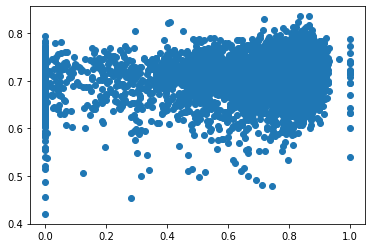

In [181]:
plt.scatter(y_test,preds)
plt.show()

In [182]:
mse = metrics.mean_squared_error(y_test,preds)
print(mse)
print(np.sqrt(mse))

0.04905797770449026
0.22149035578212037


<AxesSubplot:>

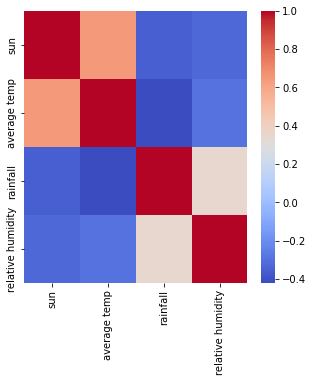

In [183]:
corr = x_train.corr()
plt.figure(figsize=(5,5))
sns.heatmap(corr, cmap='coolwarm')

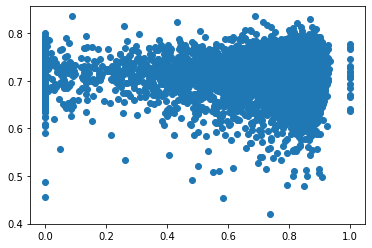

0.04833496080001369
0.219852133944644


In [184]:
#trying to linear regression by dropping co-occuring variable: sunshine hours
x2 = df[['average temp','rainfall','relative humidity']]
x_train2,x_test2,y_train2,y_test2 = train_test_split(x2,y,test_size=0.3) #split into training and testing sets
model2 = LinearRegression()
model2.fit(x_train2,y_train2)
preds2 = model2.predict(x_test2)
plt.scatter(y_test2,preds)
plt.show()
mse2 = metrics.mean_squared_error(y_test2,preds2)
print(mse2)
print(np.sqrt(mse2))

-1.9612755667749275


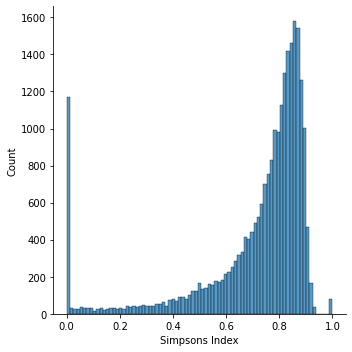

In [185]:
sns.displot(df['Simpsons Index'])
print(skew(df['Simpsons Index']))

Decision Tree:


In [186]:
x3 = df[['average temp','rainfall','relative humidity']]
x_train3,x_test3,y_train3,y_test3 = train_test_split(x3,y,test_size=0.3, random_state=44) #split into training and testing sets
model3_tree = tree.DecisionTreeRegressor()
model3_tree.fit(x_train3,y_train3)
preds3 = model3_tree.predict(x_test3)
mse3 = metrics.mean_squared_error(y_test3,preds3)
print(mse3)
print(np.sqrt(mse3))

0.08211933293450394
0.2865647098553901


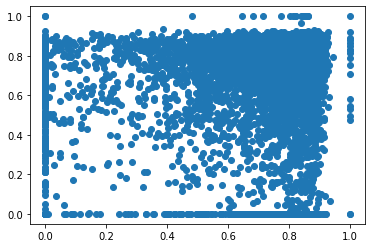

In [187]:
plt.scatter(y_test3,preds3)

In [188]:
# #decision tree hyperparameter tuning
# param_grid = {'max_depth':np. arrange(1,2,10)}
# tree_reg = GridSearchCV(tree.DecisionTreeRegressor(),param_grid=param_grid)